# Historical Hurricane Frequencies with HURDAT2 Dataset

This script plots the hurricane frequency as a function of year between 1851-present as well as 1972-present. 

Over the full period 1851-present there is an apparent increase in the frequency of hurricanes, but this apparent increase is caused by a sampling bias where hurricanes were missed unless they hit land until the advent of satellites around 1972 (e.g. Vecchi et al. 2021). When one only considers the frequency of hurricanes between 1972-present, there is no statistically significant change in the frequency of hurricanes.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [2]:
def linear_fit(x, y):
    """
    Fit a line to the provided x and y values and print the slope, p-value, and the decision based on the p-value.
    """
    # Perform linear regression using scipy's linregress function
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Print results to evaluate if the slope is consistent with no slope
    print(f"Slope: {slope}")
    print(f"P-value: {p_value}")

    # Decision based on p-value
    if p_value > 0.05:
        print("The slope is not significantly different from zero (consistent with no slope).")
    else:
        print("The slope is significantly different from zero.")

    return slope, intercept, r_value, p_value, std_err

In [3]:
df = pd.read_parquet('data/hurdat2.parquet')

In [4]:
n_cyclones = df.groupby('Year')['CycloneID'].nunique().reset_index()

In [5]:
n_cyclones = n_cyclones.rename({'CycloneID': 'n_hurricanes'}, axis=1)

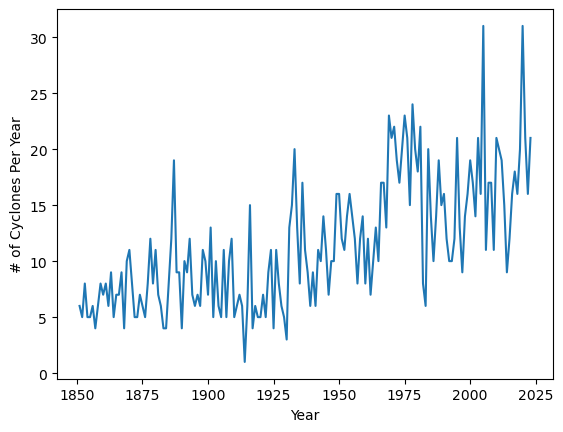

In [6]:
sns.lineplot(data=n_cyclones, x='Year', y='n_hurricanes')
plt.ylabel('# of Cyclones Per Year');

There is an apparent increase in the number of cyclones per year in the Atlantic basin, however this is due to sampling differences over the years. In early times, hurricanes were only known about and recorded if they made landfall.

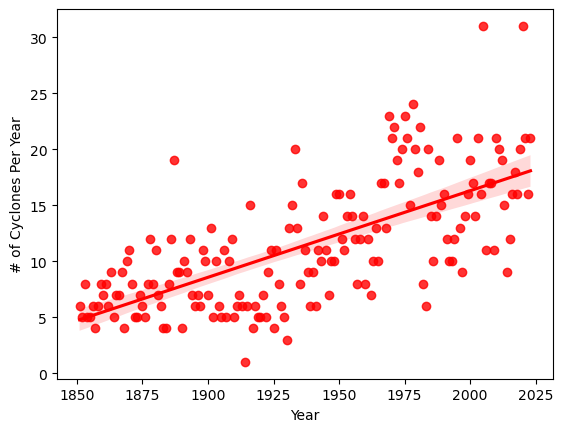

In [7]:
sns.regplot(data=n_cyclones, x='Year', y='n_hurricanes', scatter=True, color='red')
plt.ylabel('# of Cyclones Per Year');

Recent work by Vecchi et al. (2021) suggests that reliable data for hurricane frequency begins around 1972, and coincides with the advent of satellite imaging. Unless an Atlantic hurricane made landfall, it was not known about, so the true number of hurricanes in the past was higher than the number recorded in the hurdat2 dataset. 

Below I will repeat this with data from 1972-present.

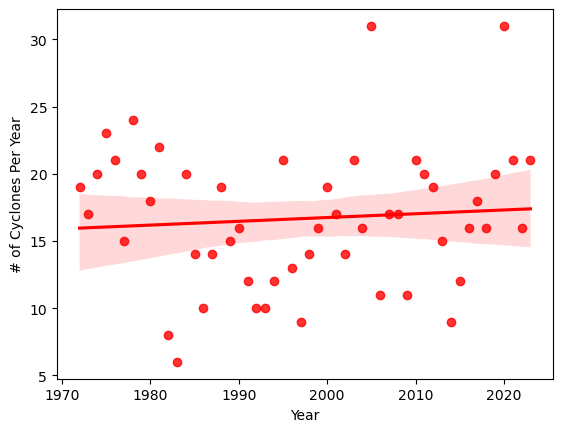

In [8]:
sns.regplot(data=n_cyclones.loc[n_cyclones.Year >= 1972], x='Year', y='n_hurricanes', scatter=True, color='red')
plt.ylabel('# of Cyclones Per Year');

C:\Users\patri\AppData\Local\Temp\ipykernel_34036\4146619926.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_cyclones_filtered['15yr_avg'] = n_cyclones_filtered['n_hurricanes'].rolling(window=15).mean()


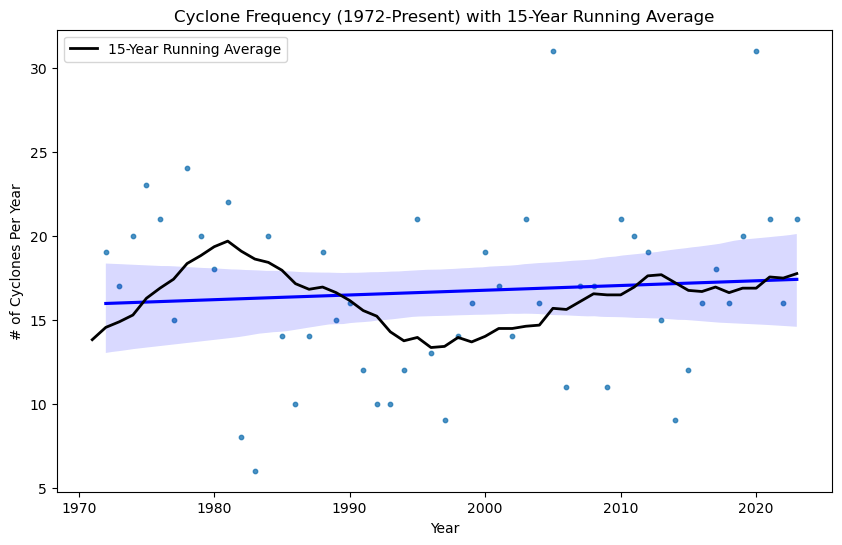

In [9]:
n_cyclones_filtered = n_cyclones[n_cyclones['Year'] >= 1972-15]

# Create a 15-year rolling average for CycloneCount
n_cyclones_filtered['15yr_avg'] = n_cyclones_filtered['n_hurricanes'].rolling(window=15).mean()

# Plotting the regplot
plt.figure(figsize=(10, 6))
sns.regplot(x='Year', y='n_hurricanes', data=n_cyclones_filtered.loc[n_cyclones['Year'] >= 1972], scatter_kws={"s": 10}, line_kws={"color": "blue"})

# Adding the 15-year running average line in black
plt.plot(n_cyclones_filtered['Year'], n_cyclones_filtered['15yr_avg'], color='black', linewidth=2, label='15-Year Running Average')

# Customize and show plot
plt.xlabel('Year')
plt.ylabel('# of Cyclones Per Year')
plt.title('Cyclone Frequency (1972-Present) with 15-Year Running Average')
plt.legend();

Let's fit a linear regression model to see if the slope measured is consistent with 0.

In [10]:
n_cyclones_filtered = n_cyclones[n_cyclones['Year'] >= 1972]

# Perform linear regression using scipy's linregress function
slope, intercept, r_value, p_value, std_err = linear_fit(n_cyclones_filtered['Year'], n_cyclones_filtered['n_hurricanes'])

Slope: 0.028131136344232904
P-value: 0.5591350824380359
The slope is not significantly different from zero (consistent with no slope).


The linear fit of data since 1972 is statistically consistent with no increase with time.

Let's see how many hurricanes we would have to see this year for a departure from normal. Assume the distribution in frequency is unchanged since 1972 and take 2 standard deviations above the mean. This threshold convention is a commonly used limit to differentiate outliers from inliers. It roughly corresponds to the 97.5th percentile, assuming the data is normally distributed.

In [11]:
mean_hurricanes = n_cyclones_filtered['n_hurricanes'].mean()
one_std = n_cyclones_filtered['n_hurricanes'].std()
two_std = one_std * 2

mean_hurricanes + two_std

26.960866402261658

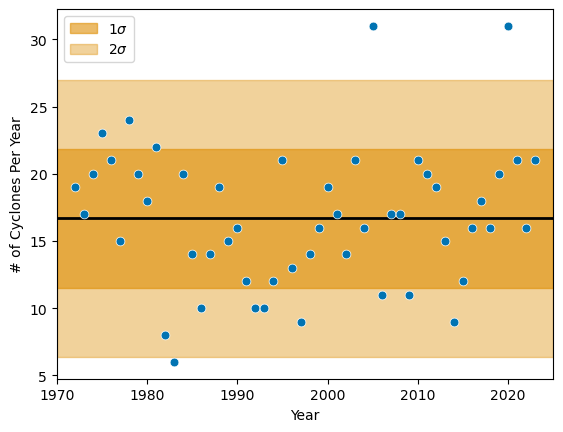

In [12]:
sns.scatterplot(data=n_cyclones.loc[n_cyclones.Year >= 1972], x='Year', y='n_hurricanes', s=40, color=sns.color_palette('colorblind')[0])
plt.axhline(mean_hurricanes, linewidth=2, color='k', zorder=0)
plt.fill_between(x=[1970, 2025], y1=mean_hurricanes - one_std, y2=mean_hurricanes + one_std, zorder=-1, alpha=0.6, color=sns.color_palette('colorblind')[1], label=r'1$\sigma$')
plt.fill_between(x=[1970, 2025], y1=mean_hurricanes - two_std, y2=mean_hurricanes + two_std, zorder=-1, alpha=0.4, color=sns.color_palette('colorblind')[1], label=r'2$\sigma$')

plt.xlim(1970, 2025)
plt.ylabel('# of Cyclones Per Year')
plt.legend();

In [13]:
n_cyclones.loc[
    (n_cyclones.Year >= 1972) &
    ((n_cyclones.n_hurricanes > mean_hurricanes + two_std) |
    (n_cyclones.n_hurricanes < mean_hurricanes - two_std))
    ]

,Year,n_hurricanes
132,1983,6
154,2005,31
169,2020,31


There have been three years with hurricane counts outside 2 standard deviations. 1983 is a low outlier, and 2005 and 2020 were high outliers.